In [ ]:
# Amazon Reviews Sentiment Analysis with TensorFlow

In [ ]:
# Downloading dataset from kaggle

'''
from google.colab import drive
drive.mount('/content/drive')

# Creating directory/file
! mkdir ~/.kaggle

# Copying google drive folder onto the kaggle directory
!cp /content/drive/MyDrive/Colab_Notebooks/etc/kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# Creating directory/file\n! mkdir ~/.kaggle\n\n# Copying google drive folder onto the kaggle directory\n!cp /content/drive/MyDrive/Colab_Notebooks/etc/kaggle.json ~/.kaggle/\n\n! chmod 600 ~/.kaggle/kaggle.json\n"

In [ ]:
# Download and unzip file
! kaggle datasets download -d arhamrumi/amazon-product-reviews
! unzip amazon-product-reviews.zip


Dataset URL: https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews
License(s): CC0-1.0
100% 114M/115M [00:06<00:00, 23.1MB/s]
100% 115M/115M [00:06<00:00, 18.0MB/s]
Archive:  amazon-product-reviews.zip
  inflating: Reviews.csv             


Once we download the data, we read it into pandas to do some data manipulation like selecting the columns of interest and changing the response variable which is rating from 1 to 5, to a binary class (good or bad)

In [ ]:
import pandas as pd

df = pd.read_csv('Reviews.csv')
df['Score'] = df['Score'].replace({5:"Good", 4:"Good", 3:"Bad", 2:"Bad", 1:"Bad"})

In [ ]:
df1 = df.copy()[['Text', 'Score']]

df1.head()

,Text,Score
0,I have bought several of the Vitality canned d...,Good
1,Product arrived labeled as Jumbo Salted Peanut...,Bad
2,This is a confection that has been around a fe...,Good
3,If you are looking for the secret ingredient i...,Bad
4,Great taffy at a great price. There was a wid...,Good


We then preprocess the data for sentiment analysis. This involves removing any non alphabetical characters, making all of the text lowercase, and replacing our reponse with 0 and 1 for modeling.

In [ ]:
import re

# ReGex replacing all non alphabetical characters with an empty string
df1["Text"] = df1["Text"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
# Making sure all characters are lowercase
df1['Text'] = df1["Text"].str.lower()
# Converting labels to integers
df1['Score'] = df1['Score'].replace({"Good": 1, "Bad": 0})

df1.rename(columns = {
    'Score': 'label',
    'Text': 'text'
},inplace = True)

df1.head()

,text,label
0,i have bought several of the vitality canned d...,1
1,product arrived labeled as jumbo salted peanut...,0
2,this is a confection that has been around a fe...,1
3,if you are looking for the secret ingredient i...,0
4,great taffy at a great price there was a wide...,1


Next we take a look at the distribution of our reponse. We see that there are more positive reviews than negative reviews.

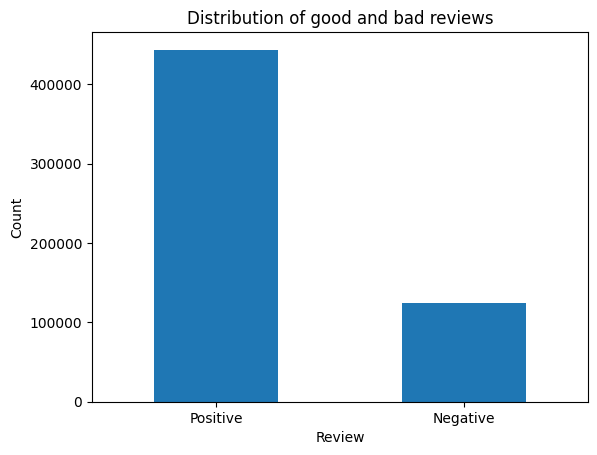

In [ ]:
import matplotlib.pyplot as plt

plot = df1['label'].value_counts().plot(kind = 'bar')
plot.set_xticklabels(['Positive', 'Negative'])
plt.xlabel('Review')
plt.ylabel('Count')
plt.title('Distribution of good and bad reviews')
plt.xticks(rotation=0)
plt.show()

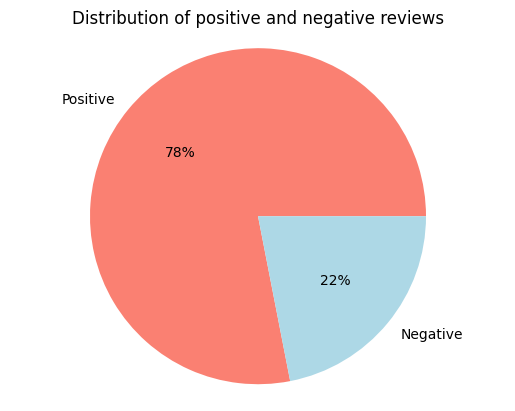

In [ ]:
labels=['Positive', 'Negative']
colors = ['salmon','lightblue']
sizes=[df1['label'].value_counts()[1],
     df1['label'].value_counts()[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%')
ax1.axis('equal')
ax1.set_title('Distribution of positive and negative reviews')
plt.show()

In [ ]:
# Set our x and y (text and labels)

texts = df1['text']
labels = df1['label']

Lets start creating the model!

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

'''
Preprocessing layer which maps text features to integer sequences

Steps:
Tokenizer: converts words/letters into numeric data
tokenizer.adapt(): layer is adapted, it will analyze the dataset,
determine the frequency of individual string values,
and create a vocabulary from them.
'''

tokenizer = tf.keras.layers.TextVectorization(max_tokens = 10000)
tokenizer.adapt(texts)

In [ ]:
'''
This process involved using the created word vocabulary to convert
each text into a sequence of integers

Padded sequences() involves add zeros to the end of each sequences
to make sure all the sequences are of the same length.
'''
import pickle

sequences = tokenizer(texts)
print(sequences)

# Save the tokenizer
with open('/content/drive/MyDrive/Colab_Notebooks/etc/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

padded_sequences = pad_sequences(sequences)
print(padded_sequences)

tf.Tensor(
[[   3   17  122 ...    0    0    0]
 [  43  369 2184 ...    0    0    0]
 [  10    9    5 ...    0    0    0]
 ...
 [  28  383   20 ...    0    0    0]
 [  28   20    2 ...    0    0    0]
 [   3   90   39 ...    0    0    0]], shape=(568454, 3414), dtype=int64)
[[   3   17  122 ...    0    0    0]
 [  43  369 2184 ...    0    0    0]
 [  10    9    5 ...    0    0    0]
 ...
 [  28  383   20 ...    0    0    0]
 [  28   20    2 ...    0    0    0]
 [   3   90   39 ...    0    0    0]]


In [ ]:
import numpy as np

print("Number of unique labels:", len(np.unique(labels)))
print("Number of unique words:", len(tokenizer.get_vocabulary()))

Number of unique labels: 2
Number of unique words: 10000


In [ ]:
len(labels) ==len(padded_sequences)

True

We checked that our data is good after the embedding and tokenization process. Now lets split the data.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size = 0.2)

In [ ]:
# Convert to tensors so that they can be ran through the neural network

x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

In [ ]:
# Create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

'''
Sequential model is an appropriate model for a plain stack of layers
where each layer has exactly one input tensor and one output tensor.
Like a pipeline for each of the parts of the model.
Good for inputs or outputs that involve sequences of data.

Embedding is a way to represent categorical data (words in a sentence)
as dense vectors of real numbers
In our case since we have 10,000 unique words, each column in that vector
represents a unique word, and a 1 at a certain index represents the presence
of that word in the sentence.
mask_zero = True takes into account the padding zeros in the sequences.

Recurrent Neural Network (RNN)
A neural network that has the presence of feedback connections that allows the
flow of information to persist For example when information
flows from one part to another the model will remember the previous input
for future use (has a memory state in neuron) though it is short term memory.

LTSM: Long Short-Term Memory:
A LTSM model is an improved version of RNN, as it has memory cell that can
remember information for longer periods of time.
Fixes the problem of vanishing gradients in a regular RNN by incorporating
a long-term memory state and a gating mechanism which controls the amount of
information that is passed through the network.
(What percentage of the information to forget, retain, etc.)

Dense Layer:
A dense layer is a layer of neurons where each neuron is connected to
every neuron in the previous layer. Usually used in the final stages of the
model.
Adding bias shifts the activation function which is used to offset the result,
bias adds flexibility to the model. Think of nudging a steer wheel even while the
car is driving straight. Can help prevent overfitting.

Activation function: Goal is to introduce non-linearity into the model, allowing
the model to learn more complex patterns in the data.
Activation function decides whether a neuron should be activated
or not by calculating the weighted sum and further adding bias to it.
Activations make back-prop possible since they return the loss/gradient to
previous layers since they are differentiable, which allows the model to
learn and adjust the weights/biases accordingly.
We will use a sigmoid function for our output dense layer  in this case
because we have a binary classification problem
 and we are using an RNN model.
'''


model = Sequential([
    Embedding(input_dim = len(tokenizer.get_vocabulary()), output_dim = 64,
    mask_zero = True),
    LSTM(64),
    Dense(1, activation = "sigmoid")])


In [ ]:
# Compile the model

'''
Binary cross entropy is a measure of the dissimilarity between actual and predicted
probabilities of points in the positive class.
Penalizing wrong confident predictions

Adam is an optimization algorithm that can be used instead of the classical stochastic
gradient descent to update network weights iteratively to minimize a cost function.
Adam is a mix of AdaGrad and RMSProp algorithms.
Adaptive learning rate algorithm. Which means it dynamically adjusts the learning
rate for each individual parameter within a model, rather than using a single
global learning rate.
It is used because of its performance, it can handle sparse gradients, and it
converges quickly because of its adaptive learning rate.
'''

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [ ]:
'''
This gets the logs which includes metrics of the model for each epoch
after it has been trained
'''

from keras.callbacks import CSVLogger

csv_logger = CSVLogger('/content/drive/MyDrive/Colab_Notebooks/etc/training1.log', separator=',', append=False)

In [ ]:
'''
Batch_size determines how to bunch up the data to go through the network at once
For example batch_size = 1000 will take the first 1000 observations to go through
the network and then the next 1000 observations and so on
By default, when batch_size is not specified, the batch size is set to 32.
'''

history = model.fit(x_train, y_train, epochs = 10, batch_size = 64,
                    validation_data = (x_test, y_test),
                    callbacks = [csv_logger])

Epoch 1/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 165s 23ms/step - accuracy: 0.8794 - loss: 0.2916 - val_accuracy: 0.9227 - val_loss: 0.1911
Epoch 2/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 160s 23ms/step - accuracy: 0.9355 - loss: 0.1703 - val_accuracy: 0.9331 - val_loss: 0.1744
Epoch 3/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 161s 23ms/step - accuracy: 0.9494 - loss: 0.1358 - val_accuracy: 0.9392 - val_loss: 0.1622
Epoch 4/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 161s 23ms/step - accuracy: 0.9592 - loss: 0.1106 - val_accuracy: 0.9405 - val_loss: 0.1639
Epoch 5/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 160s 22ms/step - accuracy: 0.9666 - loss: 0.0927 - val_accuracy: 0.9409 - val_loss: 0.1704
Epoch 6/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 160s 22ms/step - accuracy: 0.9732 - loss: 0.0759 - val_accuracy: 0.9427 - val_loss: 0.1759
Epoch 7/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 164s 23ms/step - accuracy: 0.9777 - loss: 0.0631 - val_accuracy: 0.9421 - val_loss: 0.1920
Epoch 8/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 161s 23ms/step - accuracy: 

In [ ]:
# Function to graph the metrics of training and validation

from matplotlib import pyplot as plt

def plot_metrics(history, metric_name):
  metric = history.history[metric_name]
  val_metric = history.history["val_" + metric_name]

  epochs = range(1, len(metric)+1)
  plt.plot(epochs, metric, "blue", label = metric_name)
  plt.plot(epochs, val_metric, "b--", label = "val_" + metric_name)
  plt.xlabel("Epochs")
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

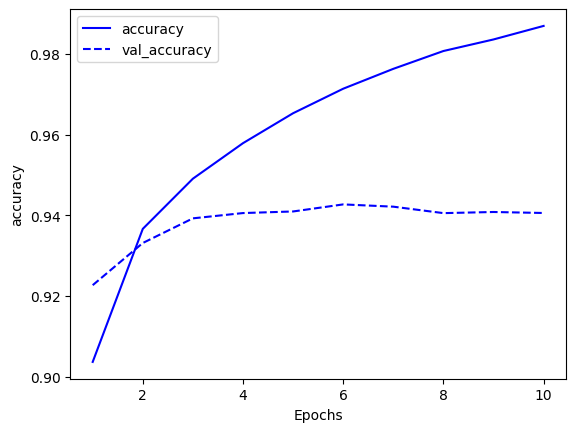

In [ ]:
plot_metrics(history, "accuracy")

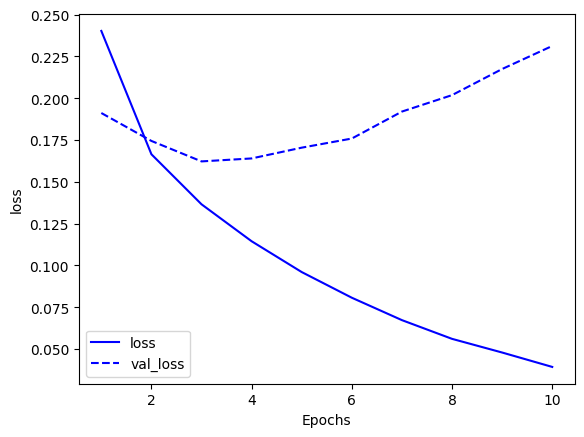

In [ ]:
plot_metrics(history, "loss")

In [ ]:
# Evaluating the model

accuracy = model.get_metrics_result()["accuracy"]
loss = model.get_metrics_result()["loss"]

print("Loss:", loss)
print("Accuracy:", accuracy)

Loss: 0.23121434450149536
Accuracy: 0.9405581951141357


It seems like our model dimminishes in performace after the 4th epoch, and the model starts overfitting the training data. Therefore let's incorporate early stopping and some regularization to avoid overfitting.

In [ ]:
from keras.callbacks import EarlyStopping

# Patience is if the model decreases in performance after 3 epochs

early_stopping = EarlyStopping(monitor = "val_loss", patience = 3,
                               restore_best_weights = True)

csv_logger2 = CSVLogger('/content/drive/MyDrive/Colab_Notebooks/etc/training2.log', separator=',', append=False)

In [ ]:
# Add some regularization add apply early stopping to reduce the complexity
# We will use l2 (Ridge) to penalizes the loss based on the squared sum of the weights

regularized_model = Sequential([
    Embedding(input_dim = len(tokenizer.get_vocabulary()), output_dim = 64,
    mask_zero = True),
    LSTM(64, kernel_regularizer = tf.keras.regularizers.l1(0.001)),
    Dense(1, activation = "sigmoid")])

regularized_model.compile(loss = "binary_crossentropy", optimizer = "adam",
                          metrics = ["accuracy"])

history2 = regularized_model.fit(x_train, y_train, epochs = 10, batch_size = 64,
                    validation_data = (x_test, y_test),
                    callbacks = [early_stopping, csv_logger2])

Epoch 1/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 167s 23ms/step - accuracy: 0.8679 - loss: 0.3753 - val_accuracy: 0.8989 - val_loss: 0.2601
Epoch 2/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 163s 23ms/step - accuracy: 0.9077 - loss: 0.2456 - val_accuracy: 0.9176 - val_loss: 0.2235
Epoch 3/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 162s 23ms/step - accuracy: 0.9259 - loss: 0.2065 - val_accuracy: 0.9219 - val_loss: 0.2117
Epoch 4/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 162s 23ms/step - accuracy: 0.9333 - loss: 0.1886 - val_accuracy: 0.9254 - val_loss: 0.2078
Epoch 5/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 161s 23ms/step - accuracy: 0.9395 - loss: 0.1761 - val_accuracy: 0.9270 - val_loss: 0.2029
Epoch 6/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 163s 23ms/step - accuracy: 0.9429 - loss: 0.1669 - val_accuracy: 0.9307 - val_loss: 0.1991
Epoch 7/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 162s 23ms/step - accuracy: 0.9469 - loss: 0.1580 - val_accuracy: 0.9297 - val_loss: 0.2053
Epoch 8/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 161s 23ms/step - accuracy: 

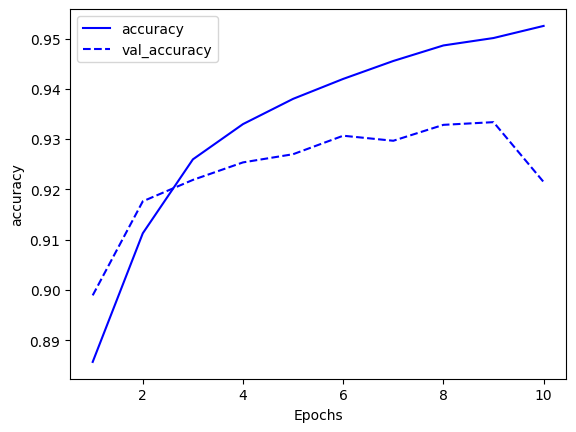

In [ ]:
plot_metrics(history2, "accuracy")


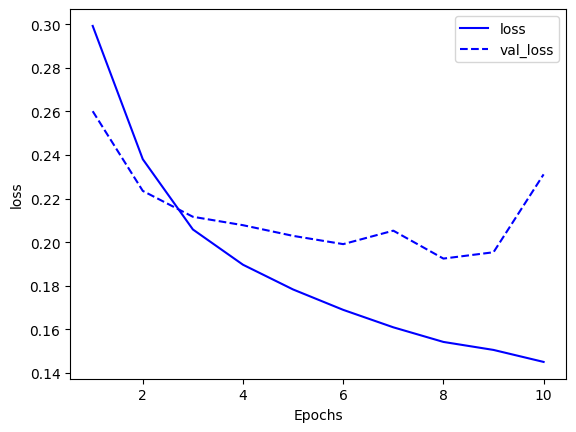

In [ ]:
plot_metrics(history2, "loss")

Loss and accuracy of our regularized model doesn't seem to perform any better than our inital model. Lets try to train our inital model again but include early stopping and try to reduce the unit number in our LSTM model to reduce the model complexity.

In [ ]:
model3 = Sequential([
    Embedding(input_dim = len(tokenizer.get_vocabulary()), output_dim = 64,
    mask_zero = True),
    LSTM(32),
    Dense(1, activation = "sigmoid")])

model3.compile(loss = "binary_crossentropy", optimizer = "adam",
                          metrics = ["accuracy"])

In [ ]:
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3,
                               restore_best_weights = True)
csv_logger3 = CSVLogger('/content/drive/MyDrive/Colab_Notebooks/etc/training3.log', separator=',', append=False)

history3 = model3.fit(x_train, y_train, epochs = 10, batch_size = 64,
                    validation_data = (x_test, y_test),
                    callbacks = [csv_logger, early_stopping])

Epoch 1/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 165s 23ms/step - accuracy: 0.8784 - loss: 0.2907 - val_accuracy: 0.9240 - val_loss: 0.1957
Epoch 2/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 160s 22ms/step - accuracy: 0.9343 - loss: 0.1713 - val_accuracy: 0.9338 - val_loss: 0.1701
Epoch 3/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 160s 23ms/step - accuracy: 0.9487 - loss: 0.1367 - val_accuracy: 0.9370 - val_loss: 0.1671
Epoch 4/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 160s 23ms/step - accuracy: 0.9573 - loss: 0.1154 - val_accuracy: 0.9400 - val_loss: 0.1635
Epoch 5/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 161s 23ms/step - accuracy: 0.9649 - loss: 0.0975 - val_accuracy: 0.9389 - val_loss: 0.1716
Epoch 6/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 160s 23ms/step - accuracy: 0.9693 - loss: 0.0873 - val_accuracy: 0.9421 - val_loss: 0.1845
Epoch 7/10
7106/7106 ━━━━━━━━━━━━━━━━━━━━ 160s 22ms/step - accuracy: 0.9757 - loss: 0.0700 - val_accuracy: 0.9387 - val_loss: 0.1879


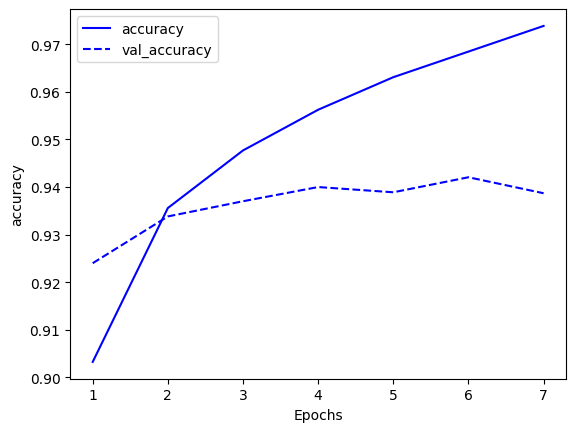

In [ ]:
plot_metrics(history3, "accuracy")

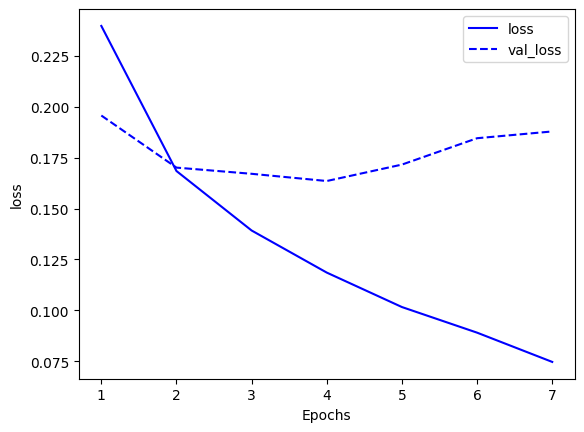

In [ ]:
plot_metrics(history3, "loss")

This model seems to be performing around the same as our initial model with a validation accuracy of around 94% and loss of around 0.16. However, lets select this model since it stopped training after the 7th epoch and will be less prone to overfitting and should provide a better generalization of the model for new data.

In [ ]:
# Running predictions

predictions = model3.predict(x_test)

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step


In [ ]:
# Since the output of the model is between 0 and 1, I will convert them to binary

predictions_binary = np.where(predictions < 0.5, 0, 1)

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# ROC Curve, plot of true positive vs false positive rates
# Shows how well the model distinguishes between positive and negative classes

roc_auc_score(y_test, predictions_binary)

0.9086136471108238

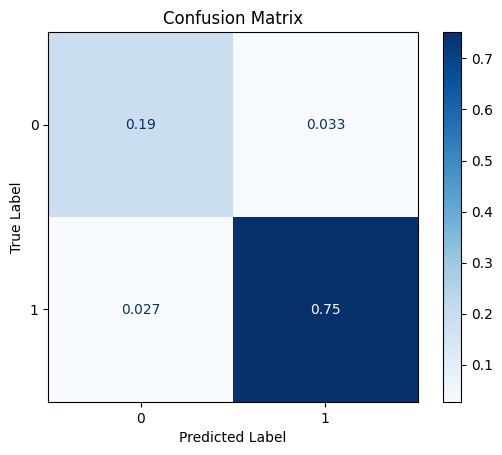

In [ ]:
# Confusion matrix.

from functools import cmp_to_key
cm = confusion_matrix(y_test, predictions_binary)

cm_dist = ConfusionMatrixDisplay(cm/cm.sum())

cm_dist.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Precision is 0.9578, therefore 96.52% of the positive predictions done by our model will be correct.

`(Precision = True Positive / (True Positive + False Positive))`

Recall is 0.9652, therefore our model will be able to correctly predict positive values 95.78% of the time.

`(Recall = True Positive / (True Postive + False Negative))`

In [ ]:
# Save the model
model3.save("/content/drive/MyDrive/Colab_Notebooks/etc/amazon_reviews_model.keras")

In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/etc/amazon_reviews_model.keras')

In [ ]:
# Get tokenizer
with open('/content/drive/MyDrive/Colab_Notebooks/etc/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
'''
Function to have the model predict reviews
Output of the model is a probability from 0 to 1 of the review being positive
(from sigmoid activation function in our dense layer)
'''

def predict_review(review):
  # Preprocesses the review
  test_sequences = tokenizer(review)
  test_padded_sequences = pad_sequences([test_sequences])

  # Runs the prediction
  prediction = loaded_model.predict(test_padded_sequences)[0][0]

  if prediction > 0.5:
    return "Positive"
  else:
    return "Negative"

In [ ]:
# Testing with a random 5 star amazon review
x = "These are the exact same cimicifuga stems as another expensive seller. I was nervous to purchase but glad I took a chance as these we are fraction of the price. I do wish they came in a long box instead of rolled up to fit in a small square one but totally worth the purchase!!! Shipping was quick too!"

predict_review(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'Positive'

Some limitations include: computing power (dealing with 500k rows of data), maybe include other regularization techniques such as dropoff. Ran models with higher more regularization which led to low accuracy and high loss scores in comparison to the models with less regularization. Also our dataset was imbalanced (biased towards positive class), perhaps find a way to make sure our dataset is even.